In [138]:
from astropy.table import Table
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import corv
import os

plt.style.use('stefan.mplstyle')

In [139]:
spyobjs = pd.read_csv('../data/raw/spy_epoch/reference_objs.csv')
spyobjs.head()

,Name,GaiaDR2,SPYTeff,SPYlogg,Rem,FileName,RAJ2000,DEJ2000,jul_date,obsname,SOURCE_ID,r_med_geo,GaiaEDR3,TeffH,e_TeffH,loggH,e_loggH
0,EC12489-2750,3495397496775173248,61045,7.63,NaN,EC12489m2750_a_2000_07_13T01_26_13_all.dat.gz,192.921000,-28.113139,2.451739e+06,ec12489m2750_a_2451738_55988057004,3495397496775173248,450.91998,3495397496775173248,NaN,NaN,NaN,NaN
1,EC12489-2750,3495397496775173248,61045,7.63,NaN,EC12489m2750_b_2000_07_15T23_51_15_all.dat.gz,192.921000,-28.113139,2.451741e+06,ec12489m2750_b_2451741_49392732,3495397496775173248,450.91998,3495397496775173248,NaN,NaN,NaN,NaN
2,HE0031-5525,4921390960477978112,11839,7.71,NaN,HE0031m5525_a_2002_07_27T06_08_16_all.dat.gz,8.400417,-55.144139,2.452483e+06,he0031m5525_a_2452482_75575103005,4921390960477978112,67.78850,4921390960477978112,11781.27,156.85,7.912382,0.022214
3,HE0031-5525,4921390960477978112,11839,7.71,NaN,HE0031m5525_b_2001_12_17T00_51_42_all.dat.gz,8.400417,-55.144139,2.452261e+06,he0031m5525_b_2452260_53590983013,4921390960477978112,67.78850,4921390960477978112,11781.27,156.85,7.912382,0.022214
4,HE0032-2744,2343355051714253056,23947,7.81,NaN,HE0032m2744_a_2002_09_15T03_00_04_all.dat.gz,8.657667,-27.472250,2.452533e+06,he0032m2744_a_2452532_62505119015,2343355051714253056,164.07458,2343355051714253056,23414.51,815.16,7.875835,0.058884


In [144]:
corvmodel = corv.models.WarwickDAModel(model_name = '3d_da_lte_h2', names = ['a', 'b', 'g', 'd'], windows = 100).model

def read_nlte_spectrum(source_id : str) -> Tuple[np.array, np.array, np.array]:
    spec = Table.read(os.path.join('..', 'data', 'raw', 'spy_epoch', 'sp_fits', f'{source_id}.fits.gz')).to_pandas()
    fit = Table.read(os.path.join('..', 'data', 'processed', 'nlte', '3d_da_lte_h2', 'ab_15aa.csv')).to_pandas()
    fitrow = fit.query(f"obsname == '{source_id}'")
    return (fitrow.nlte_rv.values[0], fitrow.nlte_teff.values[0], fitrow.nlte_logg.values[0]), spec.wavl, spec.flux, spec.ivar

def cutout_line(wavl : np.array, flux : np.array, ivar : np.array, line : str = 'a', window : float = 100.0) -> Tuple[np.array, np.array, np.array]:
    wavelengths = {'a' : 6564.61, 'b' : 4862.68, 'g' : 4341.68, 'd' : 4102.89}
    wavl_cutout, flux_cutout, ivar_cutout = corv.utils.cont_norm_line(wavl, flux, ivar, wavelengths[line], window, 10)
    mask = (0 < flux_cutout) * (flux_cutout < 1.3)
    return wavl_cutout[mask], flux_cutout[mask], ivar_cutout[mask]

def model_cutout_line(wavl : np.array, rv : float, teff : float, logg : float, line : str = 'a', window : float = 100.0) -> Tuple[np.array, np.array]:
    params = corvmodel.make_params()
    params['teff'].value = teff
    params['logg'].value = logg
    params['RV'].value = rv
    model = corvmodel.eval(params, x = wavl)
    cwavl, cmodel, _ = corv.utils.cont_norm_line(wavl, model, model, 
                                    corvmodel.centres[line], window, 10)
    civar = 999*np.ones(cwavl.shape)
    return cwavl, cmodel, civar

def get_bins(wavl : np.array, flux : np.array, ivar : np.array, samples : int = 10, num_bins : int = 20) -> Tuple[np.array, np.array]:
    fluxes = np.array([np.random.normal(loc=y, scale=sigma, size=samples) for y, sigma in zip(flux, np.sqrt(1/ivar))])
    bin_edges = np.linspace(np.min(fluxes), np.max(fluxes), num_bins + 1)
    center, e_center = [], []
    for j in range(num_bins):
        bincenters = []
        for i in range(samples):
            samp_flux = fluxes[:,i]
            mask = (bin_edges[j] < samp_flux) * (samp_flux < bin_edges[j+1])
            bincenters.append(np.mean(wavl[mask]))
        center.append(np.mean(bincenters))
        e_center.append(np.std(bincenters))
    return np.array(bin_edges), np.array(center), np.array(e_center)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


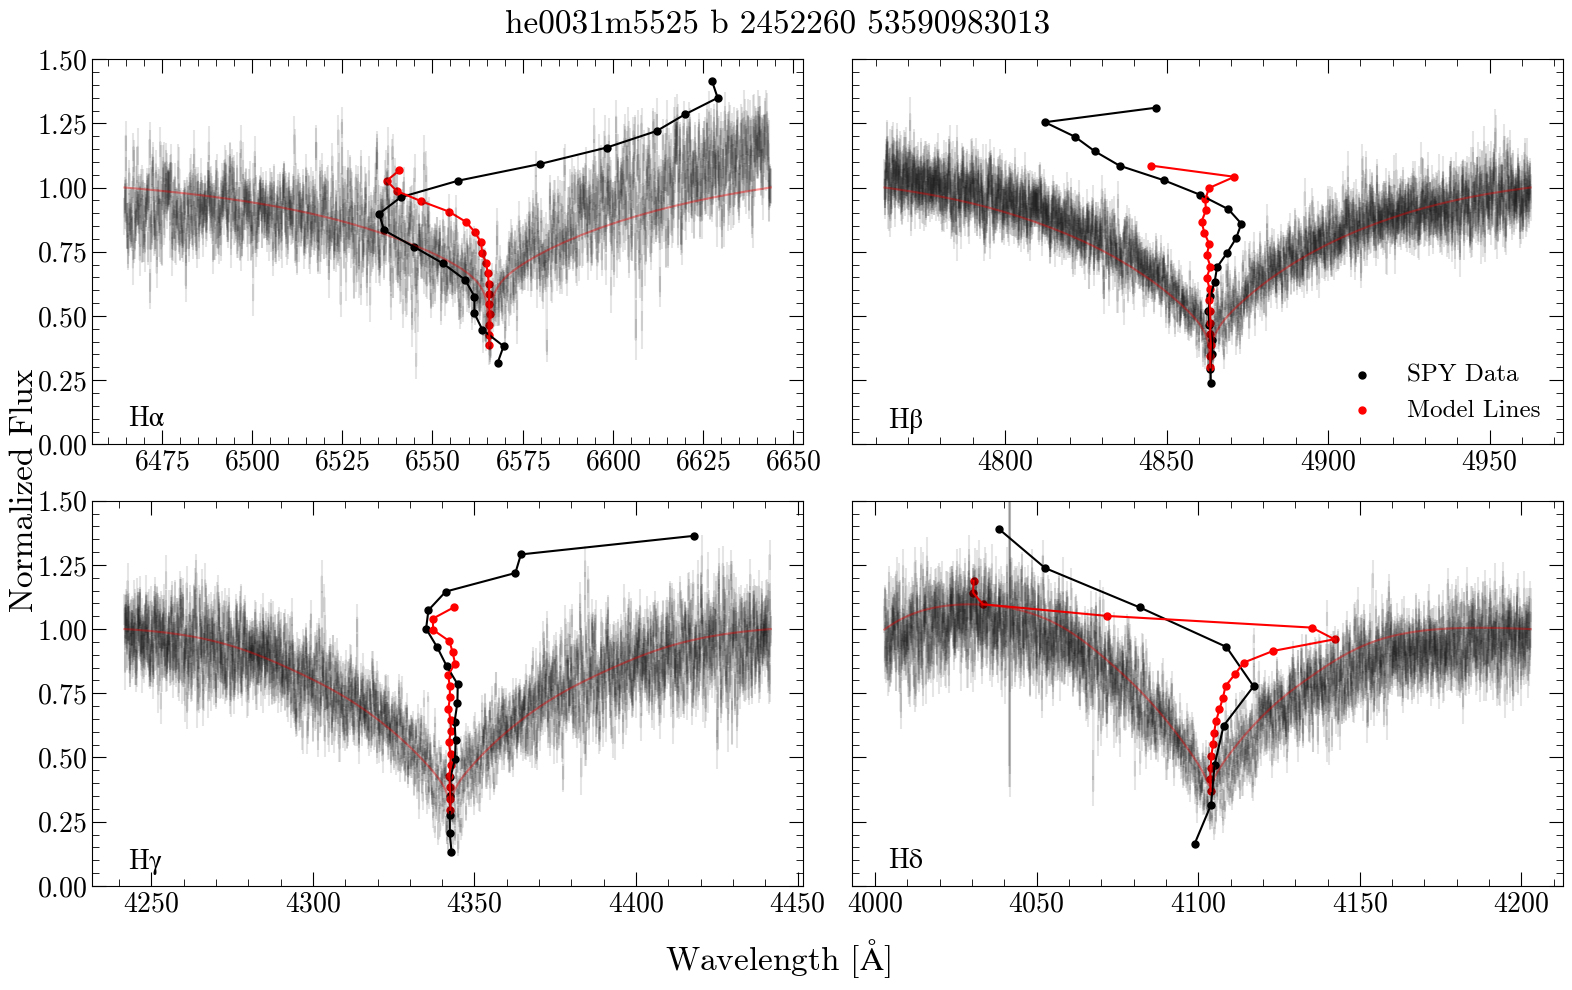

In [158]:
from tqdm import tqdm

names = {'a' : 'H$\\alpha$', 'b' : 'H$\\beta$', 'g' : 'H$\\gamma$', 'd' : 'H$\\delta$'}
obsname = spyobjs.obsname.values[3]

fig, ax = plt.subplots(ncols=2, nrows=2, sharey = True, figsize = (16, 10))
ax_flat = ax.flat
for i, line in tqdm(enumerate(names.keys()), total = len(names)):
    params, wavl, flux, ivar = read_nlte_spectrum(obsname)
    wavl_cutout, flux_cutout, ivar_cutout = cutout_line(wavl, flux, ivar, line = line, window = 100)
    bin_edges, centers, e_centers = get_bins(wavl_cutout, flux_cutout, ivar_cutout, samples = 10, num_bins = 20)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    wavl_model, flux_model, ivar_model = model_cutout_line(wavl, rv = params[0], teff = params[1], logg = params[2], line = line, window = 100)
    model_bin_edges, model_centers, model_e_centers = get_bins(wavl_model, flux_model, ivar_model, samples = 10, num_bins = 20)
    model_bin_centers = (model_bin_edges[:-1] + model_bin_edges[1:]) / 2

    ax_flat[i].errorbar(wavl_cutout, flux_cutout, np.sqrt(1/ivar_cutout), c = 'k', alpha=0.1)
    ax_flat[i].plot(wavl_model, flux_model, c='red', alpha=0.4)
    # centers of the data
    ax_flat[i].scatter(centers, bin_centers, color = 'k', label = 'SPY Data')
    ax_flat[i].plot(centers, bin_centers, color = 'k')
    # centers of the model
    ax_flat[i].scatter(model_centers, model_bin_centers, color = 'red', label = 'Model Lines')
    ax_flat[i].plot(model_centers, model_bin_centers, color = 'red')
    ax_flat[i].text(0.05, 0.10, names[line], transform=ax_flat[i].transAxes, fontsize=20, verticalalignment='top')
    ax_flat[i].set_ylim(0, 1.5)
ax_flat[1].legend(framealpha=0)
fig.supylabel('Normalized Flux', fontsize=24)
fig.supxlabel('Wavelength $[\\AA]$', fontsize=24)
fig.suptitle(obsname.replace('_', ' '), fontsize = 24)
fig.tight_layout()